In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
from __future__ import division
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
data = pd.HDFStore("train.h5", "r").get("train")

In [3]:
data_clips={'derived_0':8,'derived_1':3.5,'derived_2':10,'derived_3':10,'derived_4':10, 'fundamental_0':1, 'fundamental_1':1.5,
           'fundamental_2':20, 'fundamental_3':1.5, 'fundamental_5':1.5, 'fundamental_6':2,'fundamental_7':2.5,
            'fundamental_8':2, 'fundamental_9':2, 'fundamental_10':6, 'fundamental_11':4, 'fundamental_12':100,
           'fundamental_13':2, 'fundamental_14':2, 'fundamental_15':4, 'fundamental_16':4, 'fundamental_17':10, 
            'fundamental_18':10, 'fundamental_19':6, 'fundamental_20':4, 'fundamental_21':2, 'fundamental_22':1.5,
            'fundamental_23':4,'fundamental_24':2, 'fundamental_25':3, 'fundamental_26':2, 'fundamental_27':4,
           'fundamental_28':1.5, 'fundamental_29':4, 'fundamental_30':4, 'fundamental_31':3, 'fundamental_32':20,
            'fundamental_33':6, 'fundamental_34':150, 'fundamental_35':10, 'fundamental_36':6, 'fundamental_37':4,
           'fundamental_38':4, 'fundamental_39':3, 'fundamental_40':10, 'fundamental_41':12, 'fundamental_42':40,
           'fundamental_43':6, 'fundamental_44':6, 'fundamental_45':6, 'fundamental_46':3, 'fundamental_47':2,
           'fundamental_48':7, 'fundamental_49':3, 'fundamental_50':12, 'fundamental_51':35, 'fundamental_52':4,
           'fundamental_53':3, 'fundamental_54':2.5, 'fundamental_55':5, 'fundamental_56':6, 'fundamental_57':6,
           'fundamental_58':2.5, 'fundamental_59':2, 'fundamental_60':5, 'fundamental_61':12, 'fundamental_62':2,
           'fundamental_63':2, 'technical_0':2, 'technical_1':0.2, 'technical_2':3, 'technical_3':0.3, 'technical_5':0.2,
           'technical_6':3, 'technical_7':1.3, 'technical_9':1, 'technical_10':3, 'technical_11':3, 'technical_12':2,
           'technical_13':0.003, 'technical_14':3, 'technical_16':1, 'technical_17':3, 'technical_18':1,
           'technical_19':4, 'technical_20':0.012, 'technical_21':7, 'technical_22':0.6, 'technical_24':0.4,
           'technical_25':0.15, 'technical_27':5, 'technical_28':0.1, 'technical_29':3, 'technical_30':0.012,
           'technical_31':0.15, 'technical_32':1, 'technical_33':1, 'technical_34':0.6, 'technical_35':4,
           'technical_36':4, 'technical_37':1, 'technical_38':1, 'technical_39':1, 'technical_40':2,
           'technical_41':0.5, 'technical_42':1, 'technical_43':3, 'technical_44':0.1}

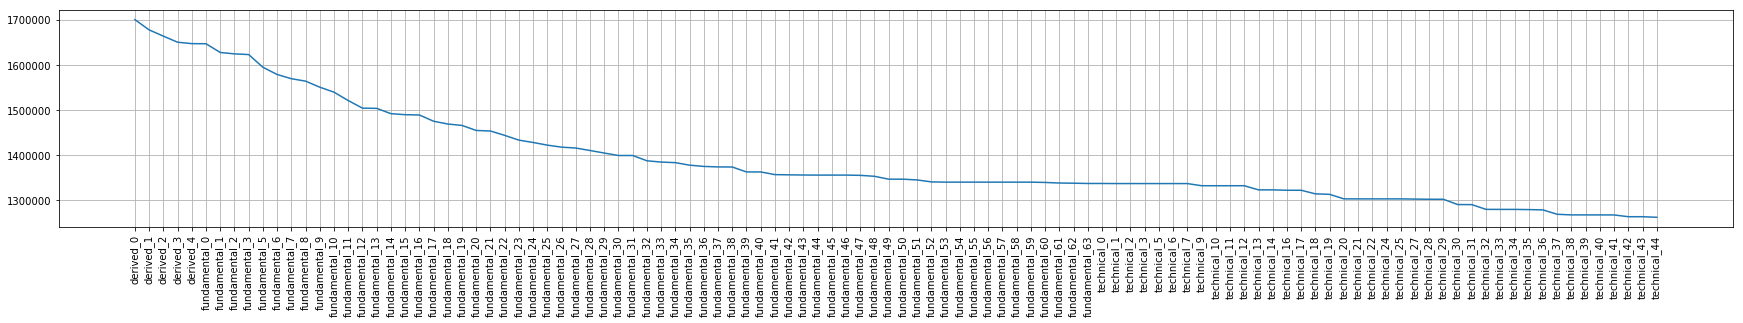

In [4]:
selected=data.id>-10000
features=[]
data_size=[]
for feature in data_clips:
    selected = selected & (((data[feature]<data_clips[feature]) & (data[feature]>-data_clips[feature])) | 
                           (data[feature].isnull()))
    features.append(feature)
    data_size.append(data[selected].shape[0])
    #print (feature, ': ', data[selected].shape)

x=range(len(features))
plt.figure(figsize=(30,4))
plt.xticks(x, features, rotation='vertical', fontsize=10)
plt.plot(x, data_size)
plt.grid()
plt.show()

In [5]:
data_cleaned=data[selected].copy()

In [6]:
selected2=['technical_20','technical_30','fundamental_11','technical_19','technical_24','id','y']
data_cleaned=data_cleaned[selected2]

In [7]:
_mean = data_cleaned.median(axis=0)
data_cleaned.fillna(_mean ,inplace=True);

In [8]:
train, test = train_test_split(data_cleaned, test_size=0.25, random_state=8, shuffle= False)
Y_train = train.y
X_train = train.drop(['y','id'], axis=1)
Y_test = test.y
X_test = test.drop(['y','id'], axis=1)

In [9]:
def r_score(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    return (np.sign(r2)*np.sqrt(np.abs(r2)))

In [10]:
epochs=5000
batch_size=1024
feature_size=X_train.shape[1]
test_size=X_test.shape[0]

In [11]:
x = tf.placeholder("float", [batch_size, feature_size])
y = tf.placeholder("float", [batch_size])
x_test = tf.constant(X_test)
weights = {
    'h1': tf.get_variable("h1", shape=[feature_size, 512],
           initializer=tf.contrib.layers.xavier_initializer()),
    'h2': tf.get_variable("h2", shape=[512, 1024],
           initializer=tf.contrib.layers.xavier_initializer()),
    'h3': tf.get_variable("h3", shape=[1024, 1024],
           initializer=tf.contrib.layers.xavier_initializer()),
    'h4': tf.get_variable("h4", shape=[1024, 512],
           initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable("out", shape=[512, 1],
           initializer=tf.contrib.layers.xavier_initializer()),
}
weights1 = {
    'h1': tf.Variable(tf.truncated_normal([feature_size, 512],mean=0.0001, stddev=0.00001)),
    'h2': tf.Variable(tf.truncated_normal([512, 1024],mean=0.0001, stddev=0.00001)),
    'h3': tf.Variable(tf.truncated_normal([1024, 1024],mean=0.0001, stddev=0.00001)),
    'h4': tf.Variable(tf.truncated_normal([1024, 512],mean=0.0001, stddev=0.00001)),
    'out': tf.Variable(tf.truncated_normal([512, 1],mean=0.0001, stddev=0.00001)),
}

biases = {
    'b1': tf.Variable(tf.random_normal([512], 0, 0.1)),
    'b2': tf.Variable(tf.random_normal([1024], 0, 0.1)),
    'b3': tf.Variable(tf.random_normal([1024], 0, 0.1)),
    'b4': tf.Variable(tf.random_normal([512], 0, 0.1)),
    'out': tf.Variable(tf.random_normal([1], 0, 0.1))
}

In [12]:
def deep_net(x, weights, biases,keep_prob=0.5):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)

    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)

    # Hidden layer with RELU activation
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.relu(layer_3)
    layer_3 = tf.nn.dropout(layer_3, keep_prob)

    # Hidden layer with RELU activation
    layer_4 = tf.add(tf.matmul(layer_3, weights['h4']), biases['b4'])
    layer_4 = tf.nn.relu(layer_4)
    layer_4 = tf.nn.dropout(layer_4, keep_prob)

    # Output layer with linear activation
    out_layer = tf.add(tf.matmul(layer_4, weights['out']), biases['out'])
    return out_layer

In [13]:
pred =   tf.transpose(deep_net(x, weights1, biases))
pred_test= deep_net(x_test, weights1, biases)
sub=pred-y
sq=tf.square(pred-y)
top=tf.nn.top_k(pred,k=1)
top_pred=pred[0,top.indices[0,0]]
top_y=x[top.indices[0,0]]
cost = tf.reduce_mean(tf.square(pred-y))
optimizer = tf.train.FtrlOptimizer(learning_rate=0.001, 
                                   l2_regularization_strength=0.5).minimize(cost)

In [14]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    random.seed(0)
    for epoch in range(epochs):
        selected=random.sample(list(X_train.index), batch_size)
        x_batch=X_train.loc[selected]
        y_batch=Y_train.loc[selected]
        _, c, pred_test_ = sess.run([optimizer, cost, pred_test], feed_dict={
                x: x_batch, y: y_batch})
        print (epoch, ' : ', c)
        print ('r_score : ', r_score(Y_test, pred_test_))


0  :  0.0136927
r_score :  -4.81597815205
1  :  0.000760835
r_score :  -0.874514963648
2  :  0.000781126
r_score :  -0.870021161124
3  :  0.000771296
r_score :  -0.865522379478
4  :  0.000751115
r_score :  -0.861200474924
5  :  0.000753183
r_score :  -0.856786204974
6  :  0.000744673
r_score :  -0.852547663053
7  :  0.000753403
r_score :  -0.848497879134
8  :  0.000746483
r_score :  -0.844330027907
9  :  0.000693656
r_score :  -0.840083675747
10  :  0.000701698
r_score :  -0.836094995772
11  :  0.000716671
r_score :  -0.832039187437
12  :  0.000668112
r_score :  -0.82794322163
13  :  0.000728082
r_score :  -0.824101564257
14  :  0.000676129
r_score :  -0.820167489496
15  :  0.000704308
r_score :  -0.81632879593
16  :  0.000704075
r_score :  -0.812510498888
17  :  0.000693545
r_score :  -0.808602756126
18  :  0.000698035
r_score :  -0.804855560576
19  :  0.000742734
r_score :  -0.801103519316
20  :  0.000716836
r_score :  -0.79723350445
21  :  0.000638765
r_score :  -0.79354834013
22  :

178  :  0.000431892
r_score :  -0.425907707753
179  :  0.00039133
r_score :  -0.424270139365
180  :  0.000399068
r_score :  -0.422816833545
181  :  0.000427131
r_score :  -0.421154408777
182  :  0.000411626
r_score :  -0.419594227322
183  :  0.000448545
r_score :  -0.418144522063
184  :  0.000420987
r_score :  -0.416703548615
185  :  0.000466692
r_score :  -0.41519790299
186  :  0.000439644
r_score :  -0.413825467523
187  :  0.000422591
r_score :  -0.41240614309
188  :  0.000458592
r_score :  -0.411043897263
189  :  0.000413597
r_score :  -0.409405276758
190  :  0.00041479
r_score :  -0.407772631332
191  :  0.000417804
r_score :  -0.406443772339
192  :  0.000432816
r_score :  -0.405029559514
193  :  0.000449639
r_score :  -0.403320937078
194  :  0.000411686
r_score :  -0.401835121797
195  :  0.000411447
r_score :  -0.400443557355
196  :  0.000456818
r_score :  -0.39904086136
197  :  0.000397759
r_score :  -0.397643439301
198  :  0.000416377
r_score :  -0.396200654554
199  :  0.00040874

354  :  0.000390473
r_score :  -0.230545805925
355  :  0.00035741
r_score :  -0.229690145196
356  :  0.000343855
r_score :  -0.229019893315
357  :  0.000336823
r_score :  -0.228105805778
358  :  0.000305849
r_score :  -0.22737854938
359  :  0.000328452
r_score :  -0.226608627191
360  :  0.000388426
r_score :  -0.225819796594
361  :  0.00036601
r_score :  -0.224919703797
362  :  0.000340312
r_score :  -0.22412466915
363  :  0.000336163
r_score :  -0.22340523252
364  :  0.000329741
r_score :  -0.222707687865
365  :  0.000323691
r_score :  -0.221927455908
366  :  0.000362314
r_score :  -0.221139586789
367  :  0.000383192
r_score :  -0.220301224042
368  :  0.00030161
r_score :  -0.21959680383
369  :  0.000391379
r_score :  -0.218938560454
370  :  0.0003595
r_score :  -0.2182599957
371  :  0.000337075
r_score :  -0.217436386272
372  :  0.000333797
r_score :  -0.216720258177
373  :  0.000370196
r_score :  -0.215935951364
374  :  0.000358003
r_score :  -0.215367738681
375  :  0.000311026
r_sc

530  :  0.000315507
r_score :  -0.125279395106
531  :  0.000313025
r_score :  -0.124887257948
532  :  0.0002983
r_score :  -0.124561295796
533  :  0.000314663
r_score :  -0.124132565814
534  :  0.000303514
r_score :  -0.123699090411
535  :  0.00027643
r_score :  -0.123281710745
536  :  0.000328624
r_score :  -0.122849830502
537  :  0.000342064
r_score :  -0.122335818807
538  :  0.000333512
r_score :  -0.122014061238
539  :  0.000313257
r_score :  -0.12160089129
540  :  0.000311903
r_score :  -0.12111493483
541  :  0.00033135
r_score :  -0.120752681747
542  :  0.000341918
r_score :  -0.120166596214
543  :  0.000367681
r_score :  -0.119659828131
544  :  0.000344679
r_score :  -0.119182370835
545  :  0.000309661
r_score :  -0.118787393121
546  :  0.000332736
r_score :  -0.118343290456
547  :  0.000297075
r_score :  -0.117949662066
548  :  0.000296021
r_score :  -0.11758356023
549  :  0.000338898
r_score :  -0.117151037666
550  :  0.000273652
r_score :  -0.11691103097
551  :  0.000326888
r

703  :  0.000297117
r_score :  -0.0696696674375
704  :  0.000354146
r_score :  -0.0695054309099
705  :  0.0003362
r_score :  -0.0691820339276
706  :  0.000299241
r_score :  -0.0688444683724
707  :  0.000328589
r_score :  -0.0686864964439
708  :  0.000315221
r_score :  -0.0685480665004
709  :  0.000304699
r_score :  -0.0683579808813
710  :  0.000324228
r_score :  -0.0680288623828
711  :  0.000270574
r_score :  -0.0677667138864
712  :  0.000280106
r_score :  -0.0675227689729
713  :  0.000312476
r_score :  -0.0672353433795
714  :  0.000316961
r_score :  -0.0669722399006
715  :  0.000312568
r_score :  -0.0668081499698
716  :  0.000263917
r_score :  -0.0666166086715
717  :  0.00033997
r_score :  -0.0664975876538
718  :  0.000281144
r_score :  -0.0663330852779
719  :  0.000337278
r_score :  -0.0661854913473
720  :  0.000278496
r_score :  -0.0660031515871
721  :  0.000358292
r_score :  -0.0657601296081
722  :  0.000367626
r_score :  -0.0655522250408
723  :  0.000352016
r_score :  -0.065282086

875  :  0.000329463
r_score :  -0.0378336097944
876  :  0.000336921
r_score :  -0.0376152684445
877  :  0.000310355
r_score :  -0.0374722728689
878  :  0.000315872
r_score :  -0.0374116953024
879  :  0.000380204
r_score :  -0.0372800503541
880  :  0.000301836
r_score :  -0.0370516019561
881  :  0.00034786
r_score :  -0.0370688762389
882  :  0.000283877
r_score :  -0.036873325763
883  :  0.000343496
r_score :  -0.0366924184395
884  :  0.000315381
r_score :  -0.0366302369716
885  :  0.000300003
r_score :  -0.036566972341
886  :  0.000281592
r_score :  -0.0365107292755
887  :  0.000316321
r_score :  -0.0364193095493
888  :  0.00030065
r_score :  -0.0361700897927
889  :  0.000275469
r_score :  -0.0361718835237
890  :  0.000367787
r_score :  -0.0360739875347
891  :  0.000355864
r_score :  -0.0359778305896
892  :  0.00029691
r_score :  -0.0358962326894
893  :  0.000274721
r_score :  -0.0358247515497
894  :  0.000300096
r_score :  -0.0356834501529
895  :  0.000258018
r_score :  -0.03562164204

1046  :  0.000332854
r_score :  -0.0214114477066
1047  :  0.000301002
r_score :  -0.021282561665
1048  :  0.000324085
r_score :  -0.0213218510218
1049  :  0.000313707
r_score :  -0.0212196441194
1050  :  0.000303174
r_score :  -0.0212260520125
1051  :  0.000342914
r_score :  -0.0211056710002
1052  :  0.00027667
r_score :  -0.0210111596545
1053  :  0.000306077
r_score :  -0.0209479422356
1054  :  0.000336676
r_score :  -0.0208369863346
1055  :  0.000281794
r_score :  -0.0206959999825
1056  :  0.00034469
r_score :  -0.0206479545747
1057  :  0.000341194
r_score :  -0.0205383280465
1058  :  0.000321691
r_score :  -0.02046041966
1059  :  0.000287122
r_score :  -0.020358491844
1060  :  0.000305136
r_score :  -0.0202784284913
1061  :  0.00029802
r_score :  -0.020170092435
1062  :  0.000314863
r_score :  -0.0201543323715
1063  :  0.000308032
r_score :  -0.0199689494654
1064  :  0.000260747
r_score :  -0.0198680186074
1065  :  0.000348125
r_score :  -0.0198563313642
1066  :  0.000309025
r_score

1215  :  0.000303862
r_score :  -0.00964299073385
1216  :  0.000300812
r_score :  -0.00968591593739
1217  :  0.000265522
r_score :  -0.00962015672385
1218  :  0.000332914
r_score :  -0.00946712576546
1219  :  0.000279935
r_score :  -0.00944539754265
1220  :  0.000351823
r_score :  -0.00944490025209
1221  :  0.000335
r_score :  -0.00931992416833
1222  :  0.000320865
r_score :  -0.00926271516893
1223  :  0.000307056
r_score :  -0.0091232441288
1224  :  0.000333844
r_score :  -0.00916225061505
1225  :  0.000345288
r_score :  -0.00898484059166
1226  :  0.00036531
r_score :  -0.00877448634611
1227  :  0.000338598
r_score :  -0.00867531074804
1228  :  0.000311412
r_score :  -0.00862991172662
1229  :  0.000283267
r_score :  -0.00849955895691
1230  :  0.000289497
r_score :  -0.00847192883887
1231  :  0.000334582
r_score :  -0.00842361021276
1232  :  0.000276239
r_score :  -0.00831079241387
1233  :  0.000300395
r_score :  -0.00810358275637
1234  :  0.000273146
r_score :  -0.00812761007759
1235 

1380  :  0.000301349
r_score :  -0.00267800045213
1381  :  0.000284495
r_score :  -0.00267176018526
1382  :  0.000275997
r_score :  -0.00273381221081
1383  :  0.000352021
r_score :  -0.00277235898895
1384  :  0.000308356
r_score :  -0.00276846770926
1385  :  0.00031627
r_score :  -0.00266968824433
1386  :  0.000328996
r_score :  -0.00262944129954
1387  :  0.000293726
r_score :  -0.00252217976308
1388  :  0.00031866
r_score :  -0.00242857157894
1389  :  0.000326501
r_score :  -0.00249227232745
1390  :  0.000318965
r_score :  -0.00241618599446
1391  :  0.000279048
r_score :  -0.00252423854633
1392  :  0.000343624
r_score :  -0.00236340637299
1393  :  0.000310726
r_score :  -0.00230250747226
1394  :  0.000307862
r_score :  -0.00233997237309
1395  :  0.000308131
r_score :  -0.00234141527273
1396  :  0.000280264
r_score :  -0.00237079849618
1397  :  0.000303896
r_score :  -0.00242754595678
1398  :  0.000323931
r_score :  -0.00233753775443
1399  :  0.000319523
r_score :  -0.00215337985526
14

1544  :  0.000312972
r_score :  -0.000131455474075
1545  :  0.000295381
r_score :  -0.000116921991455
1546  :  0.000313278
r_score :  -0.000123084539467
1547  :  0.000308387
r_score :  -7.64037928564e-05
1548  :  0.000310693
r_score :  7.36378237892e-06
1549  :  0.000327546
r_score :  -5.38925725835e-05
1550  :  0.000322089
r_score :  -8.73094741469e-05
1551  :  0.000330502
r_score :  -0.000128135610172
1552  :  0.000282159
r_score :  -0.000133361772236
1553  :  0.000299697
r_score :  -4.04910122578e-05
1554  :  0.000347814
r_score :  -5.32533561696e-05
1555  :  0.00030606
r_score :  -0.000234894296497
1556  :  0.000384323
r_score :  -0.000322731425233
1557  :  0.000322237
r_score :  -0.000343411609984
1558  :  0.000250214
r_score :  -0.000281688753286
1559  :  0.000394817
r_score :  -0.000294785086194
1560  :  0.000306967
r_score :  -0.000267712485409
1561  :  0.000288664
r_score :  -0.000276250701524
1562  :  0.000329221
r_score :  -0.0002723869335
1563  :  0.000264854
r_score :  -0.

1708  :  0.000265955
r_score :  -0.00190740397393
1709  :  0.000325951
r_score :  -0.00183753650302
1710  :  0.0003302
r_score :  -0.00170312362561
1711  :  0.000306521
r_score :  -0.00166539254819
1712  :  0.000290902
r_score :  -0.0017516053247
1713  :  0.000311302
r_score :  -0.00164533113252
1714  :  0.00036132
r_score :  -0.00165773411575
1715  :  0.000313369
r_score :  -0.00177523356993
1716  :  0.000338644
r_score :  -0.00182462270296
1717  :  0.000317902
r_score :  -0.00181220581374
1718  :  0.000299489
r_score :  -0.00181974045309
1719  :  0.000293069
r_score :  -0.00167901087935
1720  :  0.000320553
r_score :  -0.00166551381582
1721  :  0.000402445
r_score :  -0.00153888399514
1722  :  0.00033953
r_score :  -0.00156087516145
1723  :  0.000338215
r_score :  -0.00162491109097
1724  :  0.000321177
r_score :  -0.00164775095908
1725  :  0.000307541
r_score :  -0.00171874966074
1726  :  0.000339666
r_score :  -0.00180995643689
1727  :  0.00029447
r_score :  -0.00186480621953
1728  

1873  :  0.000281955
r_score :  -0.00312592248071
1874  :  0.000287818
r_score :  -0.0032053251947
1875  :  0.000321155
r_score :  -0.00323231326183
1876  :  0.000301924
r_score :  -0.00323810524759
1877  :  0.000277876
r_score :  -0.00318986669284
1878  :  0.000380826
r_score :  -0.00319204635861
1879  :  0.000324051
r_score :  -0.00316321843211
1880  :  0.000306213
r_score :  -0.0031341522397
1881  :  0.000320127
r_score :  -0.00306431173552
1882  :  0.00032441
r_score :  -0.00301948466908
1883  :  0.000343445
r_score :  -0.0031431935077
1884  :  0.000333709
r_score :  -0.00313340076797
1885  :  0.000328416
r_score :  -0.00304600367491
1886  :  0.000267639
r_score :  -0.00305132324613
1887  :  0.000309157
r_score :  -0.00306501974353
1888  :  0.000341072
r_score :  -0.00300212741283
1889  :  0.00027856
r_score :  -0.00308505814284
1890  :  0.000332616
r_score :  -0.00314542524695
1891  :  0.000324253
r_score :  -0.00302843228098
1892  :  0.000327577
r_score :  -0.00299675344165
1893 

2038  :  0.00029894
r_score :  -0.00374966448193
2039  :  0.000363735
r_score :  -0.00375283099653
2040  :  0.000313945
r_score :  -0.00372785625499
2041  :  0.000321077
r_score :  -0.0037849879799
2042  :  0.000290075
r_score :  -0.00372157577222
2043  :  0.000262116
r_score :  -0.00375847547584
2044  :  0.000297937
r_score :  -0.00382448885161
2045  :  0.000348686
r_score :  -0.00385522108559
2046  :  0.000312073
r_score :  -0.00385410273779
2047  :  0.000318742
r_score :  -0.00382673758914
2048  :  0.000315486
r_score :  -0.00380425120936
2049  :  0.000322796
r_score :  -0.0037142715648
2050  :  0.000333152
r_score :  -0.00373486067566
2051  :  0.00034984
r_score :  -0.00352644030095
2052  :  0.000346185
r_score :  -0.00346670894698
2053  :  0.000315434
r_score :  -0.0034894126549
2054  :  0.000314756
r_score :  -0.00357457940615
2055  :  0.000338361
r_score :  -0.00357054451189
2056  :  0.000335014
r_score :  -0.00364747325663
2057  :  0.000290266
r_score :  -0.00352988089997
2058 

2203  :  0.000338792
r_score :  -0.00375154184389
2204  :  0.000319692
r_score :  -0.00374534975471
2205  :  0.000409263
r_score :  -0.00368509664897
2206  :  0.000303448
r_score :  -0.00361343839918
2207  :  0.000278095
r_score :  -0.00363612979487
2208  :  0.000307719
r_score :  -0.00370876142224
2209  :  0.000328674
r_score :  -0.00364933782082
2210  :  0.000348035
r_score :  -0.0036110948828
2211  :  0.000329683
r_score :  -0.00359293640402
2212  :  0.00031303
r_score :  -0.00369709386547
2213  :  0.000285864
r_score :  -0.00366609219218
2214  :  0.000309433
r_score :  -0.00364568743555
2215  :  0.000262047
r_score :  -0.00361477515705
2216  :  0.000375292
r_score :  -0.00366322392888
2217  :  0.000299573
r_score :  -0.00358508450085
2218  :  0.000276302
r_score :  -0.00364035087338
2219  :  0.000333549
r_score :  -0.00375736133295
2220  :  0.000280046
r_score :  -0.0037864326919
2221  :  0.000281485
r_score :  -0.00388880059358
2222  :  0.0003247
r_score :  -0.00401995760234
2223 

2368  :  0.000317377
r_score :  -0.00588661041637
2369  :  0.000298658
r_score :  -0.00580120534759
2370  :  0.000288973
r_score :  -0.0059990412849
2371  :  0.000298908
r_score :  -0.00599404150537
2372  :  0.000347656
r_score :  -0.00593709207954
2373  :  0.000293475
r_score :  -0.00598121782838
2374  :  0.000314456
r_score :  -0.00591080987445
2375  :  0.000367878
r_score :  -0.00583302114277
2376  :  0.000320673
r_score :  -0.00574690980707
2377  :  0.000357804
r_score :  -0.00579938689259
2378  :  0.000304702
r_score :  -0.00580124938462
2379  :  0.000342886
r_score :  -0.00597870460438
2380  :  0.000317506
r_score :  -0.00600589217236
2381  :  0.00028209
r_score :  -0.00604412058525
2382  :  0.00030366
r_score :  -0.00608212422691
2383  :  0.000336767
r_score :  -0.00605411569849
2384  :  0.000286797
r_score :  -0.00594956341664
2385  :  0.000344676
r_score :  -0.00596346673203
2386  :  0.000326423
r_score :  -0.00577539783425
2387  :  0.000296725
r_score :  -0.00569242710884
238

2533  :  0.000301455
r_score :  -0.00603582917078
2534  :  0.000297547
r_score :  -0.0060866990258
2535  :  0.00035842
r_score :  -0.00603468076705
2536  :  0.000349106
r_score :  -0.00601369637942
2537  :  0.000318652
r_score :  -0.0060208287574
2538  :  0.000346337
r_score :  -0.00593675884866
2539  :  0.00029897
r_score :  -0.00594848729744
2540  :  0.000312616
r_score :  -0.00599533403523
2541  :  0.000341736
r_score :  -0.00597619625511
2542  :  0.000263441
r_score :  -0.00606374277315
2543  :  0.000326755
r_score :  -0.00600286378916
2544  :  0.000337505
r_score :  -0.00570388733299
2545  :  0.000304441
r_score :  -0.00566245896392
2546  :  0.000301681
r_score :  -0.00572346216038
2547  :  0.000292951
r_score :  -0.00578589621414
2548  :  0.000326819
r_score :  -0.00585770156041
2549  :  0.000321872
r_score :  -0.00586224775534
2550  :  0.000299567
r_score :  -0.00588229553432
2551  :  0.000330319
r_score :  -0.005726777678
2552  :  0.000321964
r_score :  -0.00554392933817
2553  

2698  :  0.000274372
r_score :  -0.00584495227795
2699  :  0.000304869
r_score :  -0.00581943605971
2700  :  0.00030929
r_score :  -0.00591150081499
2701  :  0.000326603
r_score :  -0.00594350046922
2702  :  0.000330289
r_score :  -0.0058709247828
2703  :  0.000332916
r_score :  -0.00591137195035
2704  :  0.000301313
r_score :  -0.00602092260643
2705  :  0.000311653
r_score :  -0.00606525621969
2706  :  0.000331714
r_score :  -0.00609983162044
2707  :  0.000372519
r_score :  -0.00601017119588
2708  :  0.00029495
r_score :  -0.00589513423943
2709  :  0.000324268
r_score :  -0.00591162998986
2710  :  0.000304694
r_score :  -0.00585339734912
2711  :  0.000316624
r_score :  -0.00590212298592
2712  :  0.000286406
r_score :  -0.00585825657802
2713  :  0.00029049
r_score :  -0.00579114768726
2714  :  0.000274585
r_score :  -0.00581080825617
2715  :  0.00027783
r_score :  -0.00579030652314
2716  :  0.000341255
r_score :  -0.00578475222248
2717  :  0.0003193
r_score :  -0.00566947215339
2718  :

2863  :  0.00036618
r_score :  -0.00629059419633
2864  :  0.000332671
r_score :  -0.00611375130997
2865  :  0.000348906
r_score :  -0.0060478761389
2866  :  0.000289923
r_score :  -0.00604793388885
2867  :  0.000308356
r_score :  -0.00605338869405
2868  :  0.000302956
r_score :  -0.00600593548569
2869  :  0.000301261
r_score :  -0.00595704572216
2870  :  0.000350369
r_score :  -0.00604915821881
2871  :  0.000341522
r_score :  -0.00611583955609
2872  :  0.000341625
r_score :  -0.00612431142607
2873  :  0.000297888
r_score :  -0.00607236180317
2874  :  0.000335377
r_score :  -0.00607623013643
2875  :  0.000323036
r_score :  -0.00618394933437
2876  :  0.000321022
r_score :  -0.0061318417032
2877  :  0.000266412
r_score :  -0.00620186403342
2878  :  0.0003282
r_score :  -0.0062674935581
2879  :  0.000338669
r_score :  -0.00611308624268
2880  :  0.00035941
r_score :  -0.00618012603642
2881  :  0.000330703
r_score :  -0.00614038714511
2882  :  0.00035168
r_score :  -0.00603512719404
2883  : 

3028  :  0.000350911
r_score :  -0.00498013970842
3029  :  0.000298481
r_score :  -0.00507335696066
3030  :  0.000355454
r_score :  -0.00497822549556
3031  :  0.000343682
r_score :  -0.00498485190331
3032  :  0.000324224
r_score :  -0.00498742563943
3033  :  0.000325003
r_score :  -0.00498701431026
3034  :  0.000321872
r_score :  -0.00489645163501
3035  :  0.000304299
r_score :  -0.00491331031905
3036  :  0.000333289
r_score :  -0.00494238198098
3037  :  0.000319124
r_score :  -0.00497763446497
3038  :  0.0003525
r_score :  -0.00507321601194
3039  :  0.000340617
r_score :  -0.00500191017167
3040  :  0.000277876
r_score :  -0.0049056847532
3041  :  0.000273755
r_score :  -0.00482712485332
3042  :  0.000311939
r_score :  -0.0047919639015
3043  :  0.000341176
r_score :  -0.00471795850628
3044  :  0.000328143
r_score :  -0.00475760101106
3045  :  0.000322726
r_score :  -0.00467591388109
3046  :  0.000326414
r_score :  -0.00452765673956
3047  :  0.00029697
r_score :  -0.00458030310576
3048 

3193  :  0.000345712
r_score :  -0.00526871276278
3194  :  0.000295523
r_score :  -0.00528120759677
3195  :  0.000337049
r_score :  -0.00536530335527
3196  :  0.00036745
r_score :  -0.00540469708944
3197  :  0.000324592
r_score :  -0.00549378897512


KeyboardInterrupt: 